<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Webs APIs and NLP
## Webscrapping Reddit Threads
## Yanda DSI 33

<img src= 'https://i.kym-cdn.com/photos/images/newsfeed/001/674/989/6ce.jpg'>

# Table of contents
1. [Background and Problem Statement](#introduction)
2. [Data Cleaning](#datacleaning)
3. [EDA and Data Visualisation](#eda) 
4. [Modelling](#modelling)
5. [Conclusion and Recommendations](#final)

# Background <a name="introduction"></a>

Smart Pet is a company made up of former vets, pet store owners and animal shelter volunteers. During the COVID-19 pandemic, there was an increase in pet ownership as people turned to animals as a form of companionship. Most commonly owned pets consist of dogs and cats. With the increase of pet owners, there is also an influx of naive owners with a lack of access to local resources for pet care in Singapore. We will be presenting an application to fellow vets, pet store owners and volunteers in the animal industry to create a model that classifies whether a post is dog or cat related. 
The data collection team has scrapped data from DogAdvice and CatAdvice for our model learning.

# Problem Statement

## An influx of inexperienced pets owners overly reliant on vets and pet store reduces work efficiency, how can we optimize it?

# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import requests
import time
import string
import re
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score, plot_roc_curve, roc_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from sklearn.feature_extraction import text

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

[nltk_data] Downloading package wordnet to C:\Users\Yan
[nltk_data]     Da\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Yan
[nltk_data]     Da\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Load Datasets
## We have scrapped user submitted posts from the CatAdvice subreddit and the DogAdvice subreddit to build our classifier model

In [2]:
dog_df = pd.read_csv('dog_csv', index_col=0)
cat_df = pd.read_csv('cat_csv', index_col=0)
print(dog_df.shape)
print(cat_df.shape)

(2000, 3)
(2000, 3)


# Data Cleaning <a name="datacleaning"></a>

### Removing Duplicates

In [3]:
dog_df.head()

,subreddit,title,selftext
0,DogAdvice,Advice on whether family member’s old school m...,My grandpa got a dog (plott hound who is curre...
1,DogAdvice,Taking dogs to daycare to get them used to eac...,TLDR: anxious 50lb dog is staying in a home wi...
2,DogAdvice,Dog hit during rehousing,"TLDR: Dog was hit by a during rehousing, but i..."
3,DogAdvice,Eye bulging a bit when chewing?,Today I noticed my corgi pup’s eye looking a b...
4,DogAdvice,Vet cut nails today. Does anyone else's dog ho...,NaN


In [4]:
dog_df[dog_df.duplicated()].head()

,subreddit,title,selftext
114,DogAdvice,Found this on our dog's leg. Any clue what thi...,NaN
195,DogAdvice,Is this ok?,She's been reverse sneezing Ike this more freq...
250,DogAdvice,Looking for best quality covered dog bed,I am wondering if anyone has suggestions for g...
251,DogAdvice,Help and advice on TICKS,So I have a 10 year old dog that I’ve had sinc...
252,DogAdvice,"This is stuck to my dog, should i pull it i do...",NaN


In [5]:
dog_df[dog_df.duplicated()].tail()

,subreddit,title,selftext
1948,DogAdvice,Need help with my multi-dog household,I have a 5 year old Australian Cattle Dog mix ...
1949,DogAdvice,How much would you pay for a pet sitter?,"Hi all! So, we have 3 dogs and a cat, and they..."
1950,DogAdvice,help!! my dog is severely bored,I very recently had to leave my job at a doggy...
1951,DogAdvice,Decreased food interest,Looking for advice. 7 month old Goldendoodle/L...
1952,DogAdvice,Swollen Pawpad,NaN


In [6]:
dog_df['selftext'].value_counts(ascending=False)

[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [7]:
cat_df['selftext'].value_counts(ascending=False)

[removed]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

dog_df.drop_duplicates(subset=['selftext'], keep= 'last' ,inplace = True)
cat_df.drop_duplicates(subset=['selftext'], keep = 'last' , inplace = True)

print(len(cat_df[cat_df.duplicated()]))
print(len(dog_df[dog_df.duplicated()]))

In [8]:
print(cat_df.shape)
print(dog_df.shape)

(2000, 3)
(2000, 3)


We can identify that most duplicates contain unique values, so we would not be dropping this series. However, a common duplicate would be `[removed]`. This are posts that have been removed from the reddit threads.

In [9]:
cat_removed_posts = cat_df['selftext'] == '[removed]'
cat_removed_posts.sum()

1192

In [10]:
dog_removed_posts = dog_df['selftext'] == '[removed]'
dog_removed_posts.sum()

12

We can observe that there are more removed posts in the CatAdvice compared to the DogAdvice subreddit. Upon further investigation, the CatAdvice subreddit have more strict regulations in posting, and posts that violate the regulations are posts that include vague and non-descriptive titles.

In [11]:
dog_title = dog_df['title'].isnull().sum()
print(f'Number of null values: {dog_title}')
dog_selftext = dog_df['selftext'].isnull().sum()
print(f'Number of null values: {dog_selftext}')
cat_title = cat_df['title'].isnull().sum()
print(f'Number of null values: {cat_title}')
cat_selftext = cat_df['selftext'].isnull().sum()
print(f'Number of null values: {cat_selftext}')

Number of null values: 0
Number of null values: 630
Number of null values: 0
Number of null values: 14


We can observe that majority of posts in the DogAdvice subreddit having missing selftext. This is due to many empty selftext queries that are posted are images or videos instead of text descriptions.

In [12]:
dog_df.fillna('', inplace=True)
cat_df.fillna('', inplace=True)

In [13]:
dog_title = dog_df['title'].isnull().sum()
print(f'Number of null values: {dog_title}')
dog_selftext = dog_df['selftext'].isnull().sum()
print(f'Number of null values: {dog_selftext}')
cat_title = cat_df['title'].isnull().sum()
print(f'Number of null values: {cat_title}')
cat_selftext = cat_df['selftext'].isnull().sum()
print(f'Number of null values: {cat_selftext}')

Number of null values: 0
Number of null values: 0
Number of null values: 0
Number of null values: 0


In [14]:
print(dog_df.loc[[1952]])

      subreddit           title selftext
1952  DogAdvice  Swollen Pawpad         


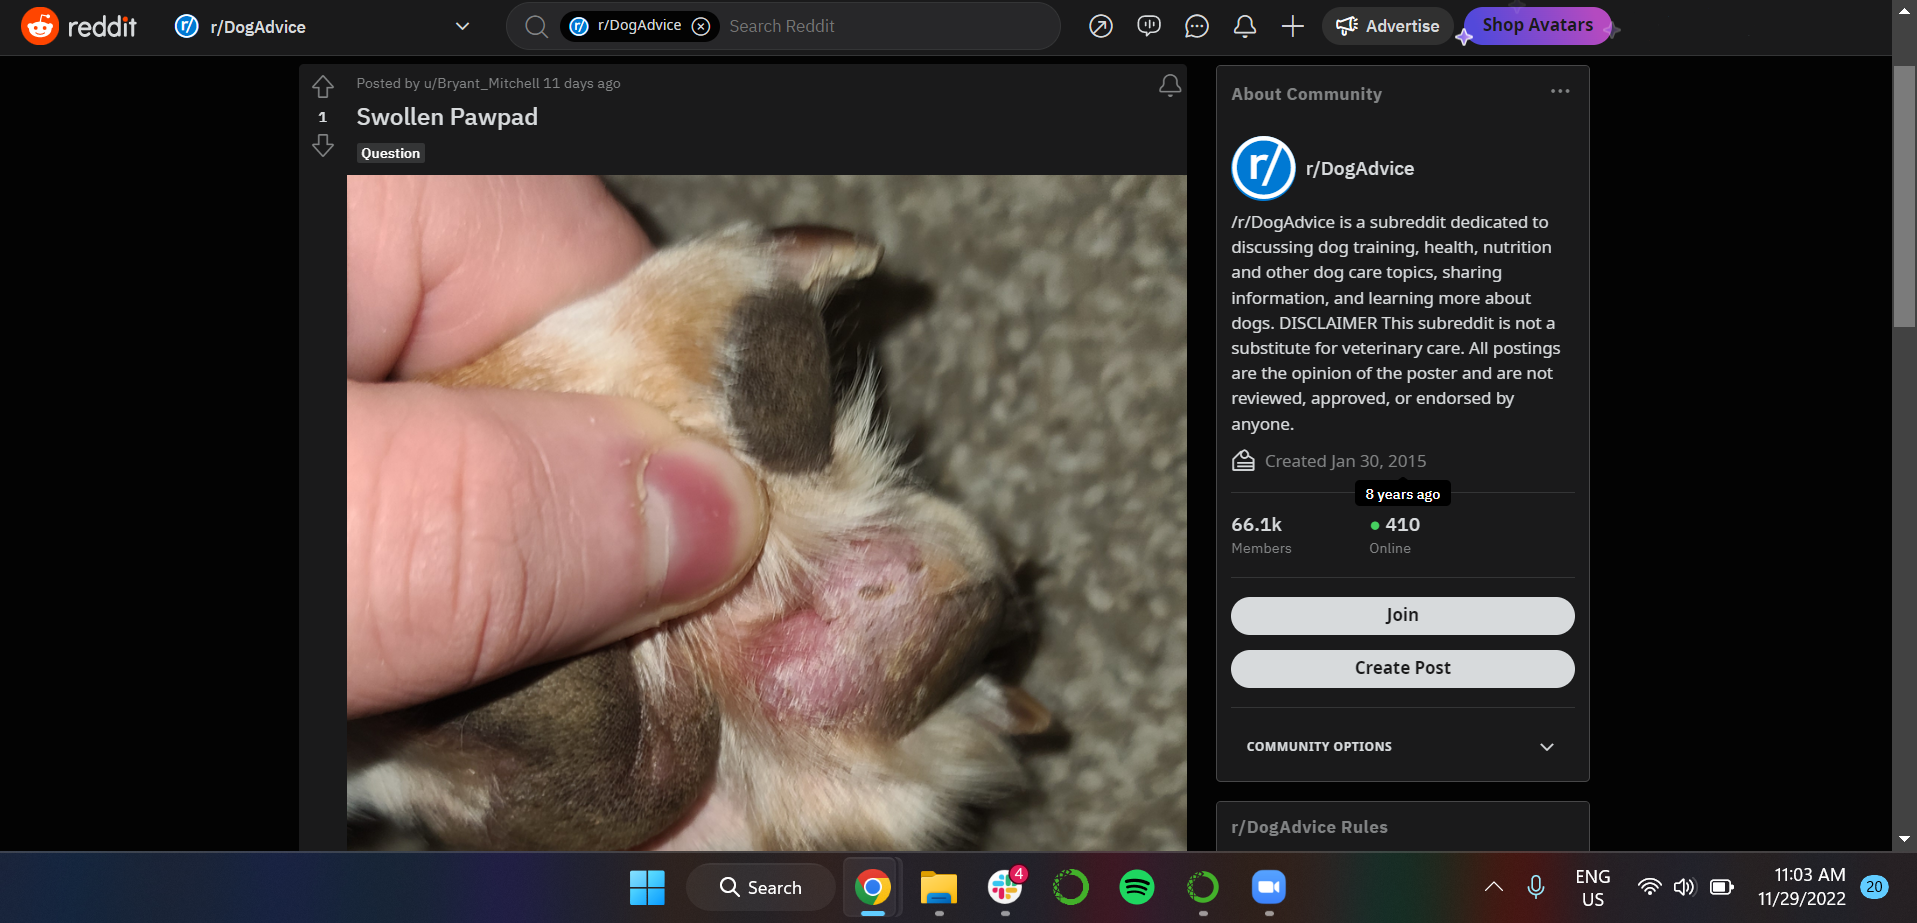

As show above, blank posts are filled with a form of visual media.

In [15]:
cat_df = cat_df[cat_df.selftext != '[removed]']
dog_df = dog_df[dog_df.selftext != '[removed]']

In [16]:
print(cat_df.shape)
print(dog_df.shape)

(808, 3)
(1988, 3)


Let's combine columns `'title'` and `'selftext'` together to form a `description` column to enable easier model analysis. 

In [17]:
dog_df['description'] = dog_df['title'] + ' ' + dog_df['selftext']
dog_df.drop(columns=['title','selftext'], inplace=True)

cat_df['description'] = cat_df['title'] + ' ' + cat_df['selftext']
cat_df.drop(columns=['title','selftext'], inplace=True)

# Natural Language Processing (NLP)

## Removing Noise (Punctuations, Websites)

In [18]:
def remove_noise(text):
    text = "".join([char for char in text if char not in string.punctuation]) # removes punctuations
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text) # removing any hyperlinks
    return text

In [19]:
cat_df['clean_description'] = cat_df['description'].apply(remove_noise)

In [20]:
dog_df['clean_description'] = dog_df['description'].apply(remove_noise)

In [21]:
cat_df.head()

,subreddit,description,clean_description
9,CatAdvice,my cat keeps knocking over water fountain My g...,my cat keeps knocking over water fountain My g...
11,CatAdvice,Whiskas perfect portions feedback Seeking some...,Whiskas perfect portions feedback Seeking some...
13,CatAdvice,Collapsed trachea in pets [collapsed trachea i...,Collapsed trachea in pets collapsed trachea in...
14,CatAdvice,Moving across states with my almost 8 year old...,Moving across states with my almost 8 year old...
17,CatAdvice,Any tips or advice on introducing a cat with d...,Any tips or advice on introducing a cat with d...


In [22]:
dog_df.head()

,subreddit,description,clean_description
0,DogAdvice,Advice on whether family member’s old school m...,Advice on whether family member’s old school m...
1,DogAdvice,Taking dogs to daycare to get them used to eac...,Taking dogs to daycare to get them used to eac...
2,DogAdvice,Dog hit during rehousing TLDR: Dog was hit by ...,Dog hit during rehousing TLDR Dog was hit by a...
3,DogAdvice,Eye bulging a bit when chewing? Today I notice...,Eye bulging a bit when chewing Today I noticed...
4,DogAdvice,Vet cut nails today. Does anyone else's dog ho...,Vet cut nails today Does anyone elses dog howl...


# EDA <a name="eda"></a>

# Commonly Repeated Words
Let's take a look at the frequent words of both data sets and the combined datasets.

In [23]:
# putting max features to extract most common 50 words 
cat_count_vect = CountVectorizer(stop_words = 'english', max_features = 50)
# fit the count vect onto our CatAdvice dataframe
cv_cat_df = cat_count_vect.fit_transform(cat_df['clean_description'])
# print the shape of top 50 words
print(cv_cat_df.shape)
print(cat_count_vect.get_feature_names())
print("")
cv_cat_df = pd.DataFrame(cv_cat_df.todense(), columns=cat_count_vect.get_feature_names_out())
print("Frequency of top 50")
print(cv_cat_df.sum().sort_values(ascending=False).head(50))
# we can see the top common word value counts for the cat df

(808, 50)
['advice', 'ago', 'away', 'cat', 'cats', 'day', 'days', 'does', 'don', 'dont', 'door', 'eat', 'feel', 'food', 'getting', 'going', 'got', 'help', 'hes', 'home', 'house', 'im', 'ive', 'just', 'kitten', 'know', 'let', 'like', 'litter', 'little', 'make', 'months', 'new', 'night', 'old', 'outside', 'play', 'really', 'room', 'started', 'stop', 'think', 'time', 'tried', 've', 'vet', 'want', 'wet', 'work', 'year']

Frequency of top 50
cat        1965
cats        720
just        677
food        659
kitten      469
like        445
old         420
time        414
im          414
new         360
know        336
litter      322
want        304
advice      298
day         289
ve          262
room        261
vet         258
house       247
getting     246
home        228
months      228
feel        220
really      216
got         213
don         212
help        208
does        207
dont        204
hes         203
play        195
going       193
year        190
let         189
eat         188

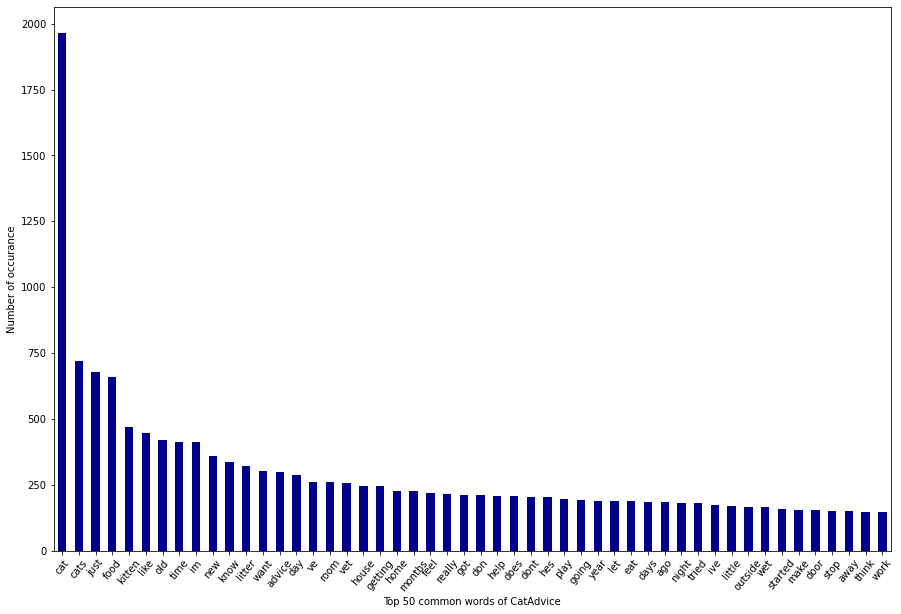

In [24]:
plt.figure(figsize=(15,10))
cv_cat_df.sum().sort_values(ascending=False).sort_values(ascending=False).plot.bar(color='darkblue')
plt.xticks(rotation=50)
plt.xlabel("Top 50 common words of CatAdvice")
plt.ylabel("Number of occurance")
plt.show()

Top common words in the CatAdvice include `cat`, `food` and `litter`. We should look to remove the keywords `cat` as they will affect the acuracy of our model.

In [25]:
# putting max features to extract most common 50 words 
dog_count_vect = CountVectorizer(stop_words = 'english', max_features = 50)
# fit the count vect onto our DogAdvice dataframe
cv_dog_df = dog_count_vect.fit_transform(dog_df['clean_description'])
# print the shape of top 50 words
print(cv_dog_df.shape)
print(dog_count_vect.get_feature_names())
print("")
cv_dog_df = pd.DataFrame(cv_dog_df.todense(), columns=dog_count_vect.get_feature_names_out())
print("Frequency of top 50")
print(cv_dog_df.sum().sort_values(ascending=False).head(50))
# we can see the top common word value counts for the dog df

(1988, 50)
['advice', 'ago', 'away', 'bed', 'bit', 'day', 'days', 'does', 'dog', 'dogs', 'doing', 'don', 'dont', 'food', 'gets', 'getting', 'going', 'good', 'got', 'help', 'hes', 'home', 'house', 'im', 'just', 'know', 'like', 'little', 'months', 'new', 'night', 'normal', 'old', 'outside', 'people', 'puppy', 'really', 'said', 'shes', 'sure', 'think', 'time', 'tried', 've', 'vet', 'want', 'weeks', 'work', 'year', 'years']

Frequency of top 50
dog        3152
just       1335
like        972
dogs        957
vet         828
old         815
know        745
time        718
im          563
puppy       537
help        519
day         498
home        478
really      472
food        462
does        461
got         448
advice      434
ve          426
don         411
want        390
year        385
going       378
days        374
new         369
shes        363
house       361
dont        351
little      341
normal      340
think       325
outside     325
months      323
ago         317
gets       

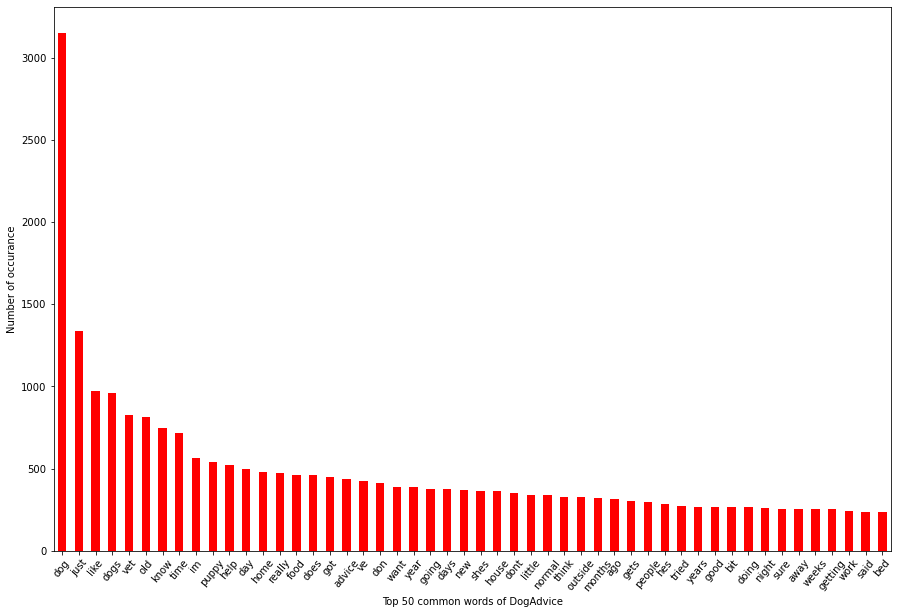

In [26]:
plt.figure(figsize=(15,10))
cv_dog_df.sum().sort_values(ascending=False).sort_values(ascending=False).plot.bar(color= 'red')
plt.xticks(rotation=50)
plt.xlabel("Top 50 common words of DogAdvice")
plt.ylabel("Number of occurance")
plt.show()

Top common words in the CatAdvice include `dog`, `puppy` and `food`. Similarly to the cat posts, We should look to remove the keywords `dog`.

# CountVectorize 
## Bigram

In [27]:
ngram_vect = CountVectorizer(stop_words = 'english', ngram_range=(2,2), max_features=25)
# obtain the top most commmon bigrams
bigram_cv_cat = ngram_vect.fit_transform(cat_df['clean_description'])

print(bigram_cv_cat.shape)
bigram_cv_cat_df = pd.DataFrame(bigram_cv_cat.todense(), columns=ngram_vect.get_feature_names_out())
print(bigram_cv_cat_df.sum().sort_values(ascending=False).head(25))

(808, 25)
wet food          143
litter box        106
dry food          103
year old          101
new cat            84
months old         74
don want           67
resident cat       62
years old          58
don know           57
dont know          53
feel like          53
old kitten         49
old cat            47
new kitten         45
cat litter         43
female cat         43
month old          43
im sure            39
months ago         38
need advice        37
cat tree           37
male cat           37
thanks advance     36
im worried         34
dtype: int64


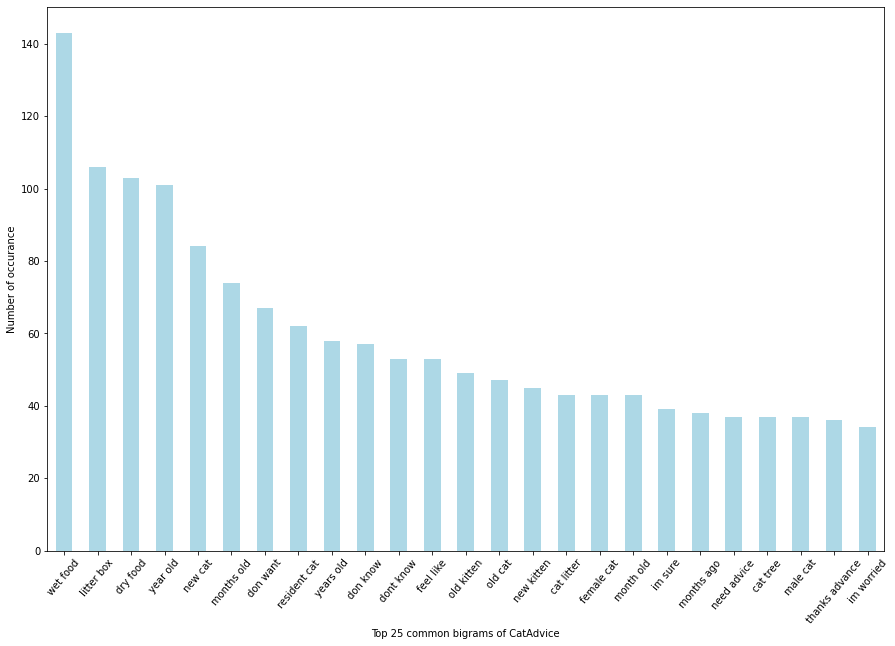

In [28]:
plt.figure(figsize=(15,10))
bigram_cv_cat_df.sum().sort_values(ascending=False).sort_values(ascending=False).plot.bar(color= 'lightblue')
plt.xticks(rotation=50)
plt.xlabel("Top 25 common bigrams of CatAdvice")
plt.ylabel("Number of occurance")
plt.show()

Majority of the bigrams for CatAdvice seem to be posts that are looking for advice on aftercare or feed for their pets.

In [29]:
ngram_vect = CountVectorizer(stop_words = 'english', ngram_range=(2,2), max_features=25)

bigram_cv_dog = ngram_vect.fit_transform(dog_df['clean_description'])

print(bigram_cv_dog.shape)
bigram_cv_dog_df = pd.DataFrame(bigram_cv_dog.todense(), columns=ngram_vect.get_feature_names_out())
print(bigram_cv_dog_df.sum().sort_values(ascending=False).head(25))
# we can see the top common word value counts for the dog df

(1988, 25)
year old              265
older dog             184
don know              164
years old             118
month old             111
dont know             109
vet said               94
months ago             84
don want               83
new puppy              76
days ago               72
feel like              70
dog just               70
dont want              66
months old             58
does know              57
weeks old              56
im sure                55
separation anxiety     49
weeks ago              49
dog food               49
make sure              49
just wondering         46
shih tzu               45
just got               44
dtype: int64


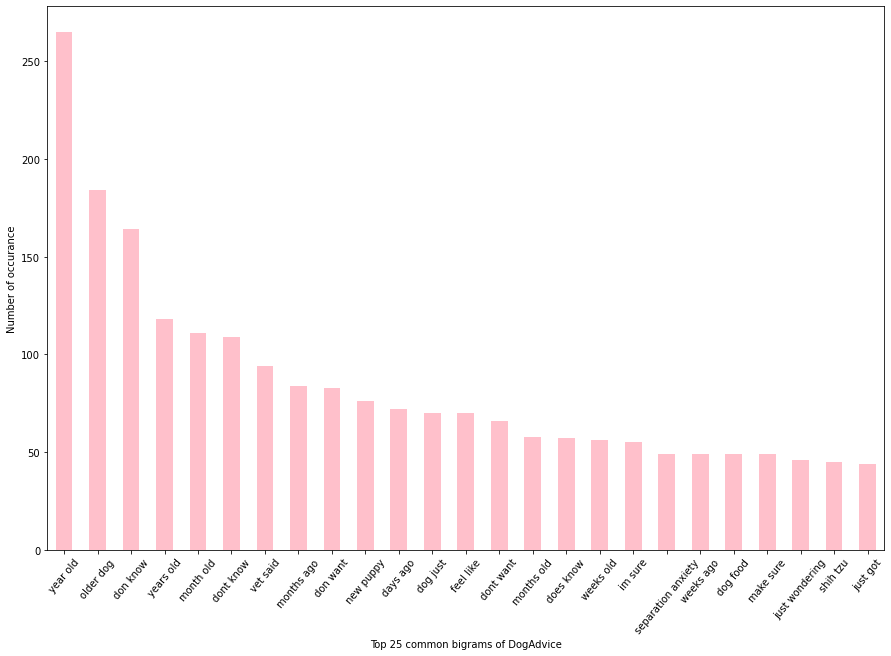

In [30]:
plt.figure(figsize=(15,10))
bigram_cv_dog_df.sum().sort_values(ascending=False).sort_values(ascending=False).plot.bar(color= 'pink')
plt.xticks(rotation=50)
plt.xlabel("Top 25 common bigrams of DogAdvice")
plt.ylabel("Number of occurance")
plt.show()

It is observed that majority of the more commonly repeated words include `older`, signifying that posts with common repeated words include the age of their dog.

## Trigrams

In [31]:
cat_trigram_vect = CountVectorizer(stop_words = 'english', ngram_range=(3,3), max_features=25)
# obtain the top most commmon bigrams
trigram_cv_cat = cat_trigram_vect.fit_transform(cat_df['clean_description'])

print(trigram_cv_cat.shape)
trigram_cv_cat = pd.DataFrame(trigram_cv_cat.todense(), columns=cat_trigram_vect.get_feature_names_out())
print(trigram_cv_cat.sum().sort_values(ascending=False).head(25))

(808, 25)
year old cat              32
month old kitten          25
tofu cat litter           15
outside litter box        15
year old male             14
cat years old             14
week old kitten           14
kittens months old        14
year old female           12
using litter box          12
food water litter         11
wet food cats             10
cat year old              10
old female cat            10
wet food morning           9
cat wet food               9
register cat microchip     9
like soft serve            9
im looking advice          9
feeding wet food           9
eat wet food               9
dry food day               9
new kitten got             9
want make sure             8
does anybody know          8
dtype: int64


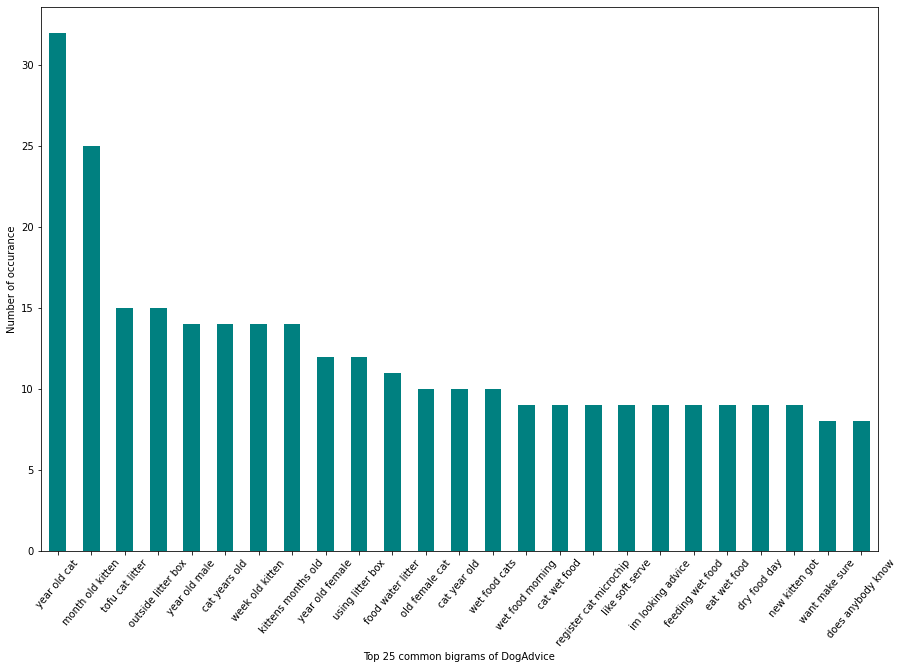

In [32]:
plt.figure(figsize=(15,10))
trigram_cv_cat.sum().sort_values(ascending=False).sort_values(ascending=False).plot.bar(color= 'teal')
plt.xticks(rotation=50)
plt.xlabel("Top 25 common bigrams of DogAdvice")
plt.ylabel("Number of occurance")
plt.show()

We can observe that `year old cat`, `month old kitten` and `tofu cat litter` appears more commonly in trigrams for CatAdvice posts. We may observe that most users in the CatAdvice reddit seek advice on newly acquired cats or kittens.

In [33]:
dog_trigram_vect = CountVectorizer(stop_words = 'english', ngram_range=(3,3), max_features=25)
# obtain the top most commmon trigrams
trigram_cv_dog = dog_trigram_vect.fit_transform(dog_df['clean_description'])

print(trigram_cv_cat.shape)
trigram_cv_dog = pd.DataFrame(trigram_cv_dog.todense(), columns=dog_trigram_vect.get_feature_names_out())
print(trigram_cv_dog.sum().sort_values(ascending=False).head(25))

(808, 25)
year old dog              30
time older dog            26
older dog depressed       26
15 year old               25
year old female           24
dog years old             20
just don know             19
want make sure            19
got new puppy             19
just got new              18
months ago dog            17
10 weeks old              17
dog year old              17
12 year old               15
just want make            15
month old puppy           15
dog keeps licking         15
15 years old              15
hes taken away            14
got months old            14
taken away mother         14
transitioning new diet    14
15 days ago               14
year old pit              14
years old know            14
dtype: int64


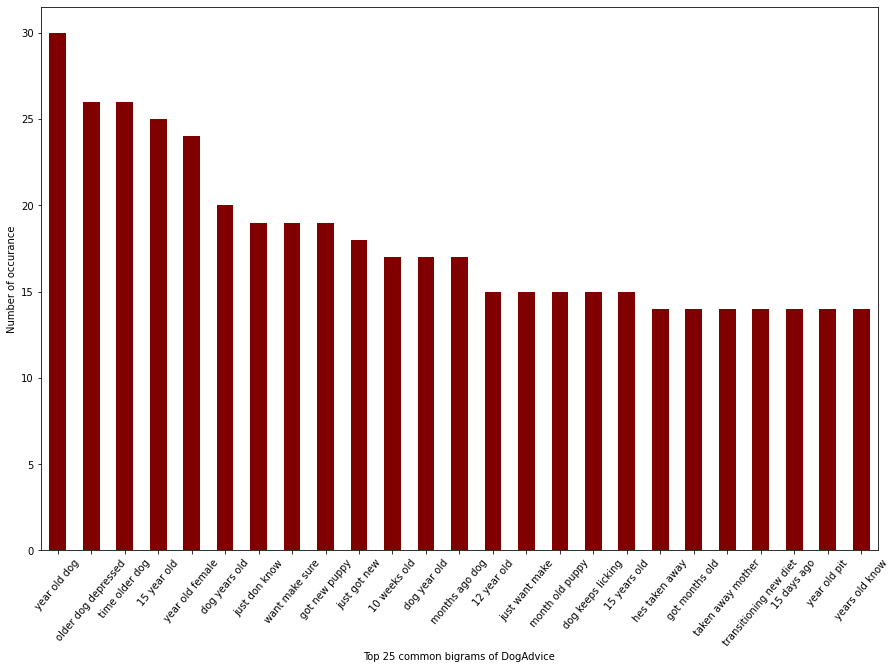

In [34]:
plt.figure(figsize=(15,10))
trigram_cv_dog.sum().sort_values(ascending=False).sort_values(ascending=False).plot.bar(color= 'maroon')
plt.xticks(rotation=50)
plt.xlabel("Top 25 common bigrams of DogAdvice")
plt.ylabel("Number of occurance")
plt.show()

We can observe that `year old dog`, `older dog depressed` and `time older dog` appears more commonly in trigrams for DogAdvice posts. Majority of DogAdvice users at the point of data collection may seek more advice for older dogs as they are more prone to medical issues.

# Removing Additional Stopwords
We will be removing more stopwords that might affect our model's accuracy. Words such as `Dog` and `Cat` are also removed so our model will not assign posts that have these keywords and will use other words to predict the classification of the post instead. 

Other common words use such as **day**, **vet** and **advice** are remove to reduce the amount of noise as they are commonly repeated words in both datasets.

In [35]:
print(dog_count_vect.get_feature_names())
print("")
print(cat_count_vect.get_feature_names())

['advice', 'ago', 'away', 'bed', 'bit', 'day', 'days', 'does', 'dog', 'dogs', 'doing', 'don', 'dont', 'food', 'gets', 'getting', 'going', 'good', 'got', 'help', 'hes', 'home', 'house', 'im', 'just', 'know', 'like', 'little', 'months', 'new', 'night', 'normal', 'old', 'outside', 'people', 'puppy', 'really', 'said', 'shes', 'sure', 'think', 'time', 'tried', 've', 'vet', 'want', 'weeks', 'work', 'year', 'years']

['advice', 'ago', 'away', 'cat', 'cats', 'day', 'days', 'does', 'don', 'dont', 'door', 'eat', 'feel', 'food', 'getting', 'going', 'got', 'help', 'hes', 'home', 'house', 'im', 'ive', 'just', 'kitten', 'know', 'let', 'like', 'litter', 'little', 'make', 'months', 'new', 'night', 'old', 'outside', 'play', 'really', 'room', 'started', 'stop', 'think', 'time', 'tried', 've', 'vet', 'want', 'wet', 'work', 'year']


In [36]:
text.ENGLISH_STOP_WORDS
# we identified that there are quite a few irrelevant words for our model classifier
add_stop_words = ['advice', 'ago', 'away', 'day', 'dog', 'dogs', 'cats', 'cat', 'days', 'does', 'doing', 'don', 'dont', 'gets', 's',
                  'getting', 'going', 'good', 'got', 'help', 'hes', 'home', 'house', 'im', 'just', 
                  'know', 'like', 'little', 'months', 'new', 'night','normal', 'outside', 
                  'people', 'really', 'said', 'shes', 'sure', 'think', 'let', 'time', 'tried', 
                  've', 'vet', 'want', 'weeks', 'work', 'year', 'years']

updated_stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

updated_stop_words

frozenset({'a',
           'about',
           'above',
           'across',
           'advice',
           'after',
           'afterwards',
           'again',
           'against',
           'ago',
           'all',
           'almost',
           'alone',
           'along',
           'already',
           'also',
           'although',
           'always',
           'am',
           'among',
           'amongst',
           'amoungst',
           'amount',
           'an',
           'and',
           'another',
           'any',
           'anyhow',
           'anyone',
           'anything',
           'anyway',
           'anywhere',
           'are',
           'around',
           'as',
           'at',
           'away',
           'back',
           'be',
           'became',
           'because',
           'become',
           'becomes',
           'becoming',
           'been',
           'before',
           'beforehand',
           'behind',
           'being',
   

# Modeling <a name="modelling"></a>
## Modelling Prep

## Combine the two datasets. 

In [37]:
cat_dog_df = pd.concat([dog_df, cat_df], axis=0)
print(cat_dog_df['subreddit'].value_counts(normalize=True))
print(cat_dog_df.shape)

DogAdvice    0.711016
CatAdvice    0.288984
Name: subreddit, dtype: float64
(2796, 3)


In [38]:
cat_dog_df['clean_description'] = cat_dog_df['description'].apply(remove_noise)

In [39]:
def tokenize(text):
    tokens = re.split('\W+', text)
    return tokens

cat_dog_df['description_tokenized'] = cat_dog_df['clean_description'].apply(lambda x: tokenize(x.lower()))

In [40]:
cat_dog_df.head()

,subreddit,description,clean_description,description_tokenized
0,DogAdvice,Advice on whether family member’s old school m...,Advice on whether family member’s old school m...,"[advice, on, whether, family, member, s, old, ..."
1,DogAdvice,Taking dogs to daycare to get them used to eac...,Taking dogs to daycare to get them used to eac...,"[taking, dogs, to, daycare, to, get, them, use..."
2,DogAdvice,Dog hit during rehousing TLDR: Dog was hit by ...,Dog hit during rehousing TLDR Dog was hit by a...,"[dog, hit, during, rehousing, tldr, dog, was, ..."
3,DogAdvice,Eye bulging a bit when chewing? Today I notice...,Eye bulging a bit when chewing Today I noticed...,"[eye, bulging, a, bit, when, chewing, today, i..."
4,DogAdvice,Vet cut nails today. Does anyone else's dog ho...,Vet cut nails today Does anyone elses dog howl...,"[vet, cut, nails, today, does, anyone, elses, ..."


In [42]:
def remove_stopwords(tokenized_list):
    text = [word for word in tokenized_list if word not in updated_stop_words]
    return text

cat_dog_df['nostop_description_tokenized'] = cat_dog_df['description_tokenized'].apply(lambda x: remove_stopwords(x))

In [43]:
cat_dog_df.head()

,subreddit,description,clean_description,description_tokenized,nostop_description_tokenized
0,DogAdvice,Advice on whether family member’s old school m...,Advice on whether family member’s old school m...,"[advice, on, whether, family, member, s, old, ...","[family, member, old, school, mentality, abusi..."
1,DogAdvice,Taking dogs to daycare to get them used to eac...,Taking dogs to daycare to get them used to eac...,"[taking, dogs, to, daycare, to, get, them, use...","[taking, daycare, used, horrible, idea, tldr, ..."
2,DogAdvice,Dog hit during rehousing TLDR: Dog was hit by ...,Dog hit during rehousing TLDR Dog was hit by a...,"[dog, hit, during, rehousing, tldr, dog, was, ...","[hit, rehousing, tldr, hit, rehousing, safely,..."
3,DogAdvice,Eye bulging a bit when chewing? Today I notice...,Eye bulging a bit when chewing Today I noticed...,"[eye, bulging, a, bit, when, chewing, today, i...","[eye, bulging, bit, chewing, today, noticed, c..."
4,DogAdvice,Vet cut nails today. Does anyone else's dog ho...,Vet cut nails today Does anyone elses dog howl...,"[vet, cut, nails, today, does, anyone, elses, ...","[cut, nails, today, elses, howl, nails, cut, a..."


# Lemmatizing

In [44]:

wn = WordNetLemmatizer()

def lemmatizing(tokenized_text):
    text = [wn.lemmatize(word) for word in tokenized_text]
    return " ".join(text)

cat_dog_df['lemm_description'] = cat_dog_df['nostop_description_tokenized'].apply(lambda x: lemmatizing(x))


In [45]:
cat_dog_df.head()

,subreddit,description,clean_description,description_tokenized,nostop_description_tokenized,lemm_description
0,DogAdvice,Advice on whether family member’s old school m...,Advice on whether family member’s old school m...,"[advice, on, whether, family, member, s, old, ...","[family, member, old, school, mentality, abusi...",family member old school mentality abusive gra...
1,DogAdvice,Taking dogs to daycare to get them used to eac...,Taking dogs to daycare to get them used to eac...,"[taking, dogs, to, daycare, to, get, them, use...","[taking, daycare, used, horrible, idea, tldr, ...",taking daycare used horrible idea tldr anxious...
2,DogAdvice,Dog hit during rehousing TLDR: Dog was hit by ...,Dog hit during rehousing TLDR Dog was hit by a...,"[dog, hit, during, rehousing, tldr, dog, was, ...","[hit, rehousing, tldr, hit, rehousing, safely,...",hit rehousing tldr hit rehousing safely today ...
3,DogAdvice,Eye bulging a bit when chewing? Today I notice...,Eye bulging a bit when chewing Today I noticed...,"[eye, bulging, a, bit, when, chewing, today, i...","[eye, bulging, bit, chewing, today, noticed, c...",eye bulging bit chewing today noticed corgi pu...
4,DogAdvice,Vet cut nails today. Does anyone else's dog ho...,Vet cut nails today Does anyone elses dog howl...,"[vet, cut, nails, today, does, anyone, elses, ...","[cut, nails, today, elses, howl, nails, cut, a...",cut nail today el howl nail cut act pain paw n...


In [46]:
model_cat_dog_df = cat_dog_df[['subreddit', 'lemm_description']]

In [47]:
model_cat_dog_df.head()

,subreddit,lemm_description
0,DogAdvice,family member old school mentality abusive gra...
1,DogAdvice,taking daycare used horrible idea tldr anxious...
2,DogAdvice,hit rehousing tldr hit rehousing safely today ...
3,DogAdvice,eye bulging bit chewing today noticed corgi pu...
4,DogAdvice,cut nail today el howl nail cut act pain paw n...


# Assign X and y

In [48]:
X = model_cat_dog_df['lemm_description']
y = model_cat_dog_df['subreddit'].map({'DogAdvice':'1', 'CatAdvice':'0'})

In [49]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify = y, random_state=10)

# Pipeline:
## Vectorizer with Models
## HyperParameter Tuning with GridSearchCV
The models will be fitted with pipeline. GridSearchCV will also be used with the pipeline to return the best model with the hyper parameters tuned.

## `CountVectorizer` + `KNN` 

In [50]:
# set n_neighbors to be 5
knn_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

In [51]:
cvec_pipe_params = {
    'cvec__max_features': [1000,1500,2000,2500,3000],
    'cvec__min_df':[2,3],
    'cvec__max_df':[0.1,0.2,0.3,0.4,0.5],
    'cvec__ngram_range':[(1,1), (2,2)] # perform on single and bigrams
}

In [52]:
gs = GridSearchCV(knn_pipe, 
                  param_grid=cvec_pipe_params,
                  cv=5) # cross validate 5 times
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'cvec__max_df': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'cvec__max_features': [1000, 1500, 2000, 2500, 3000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (2, 2)]})

In [53]:
preds = gs.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
spec = tn / (tn + fp)

print(f"GridSearch Best Score for KNN + CVEC: {gs.best_score_}")
print('')
print(f"Train score for KNN + CVEC: {gs.score(X_train, y_train)}")
print(f"Test score  for KNN + CVEC: {gs.score(X_val, y_val)}")
print('')
print('Specificity  for KNN + CVEC:', spec)

GridSearch Best Score for KNN + CVEC: 0.8268962382088872

Train score for KNN + CVEC: 0.899380066762041
Test score  for KNN + CVEC: 0.8297567954220315

Specificity  for KNN + CVEC: 0.46534653465346537


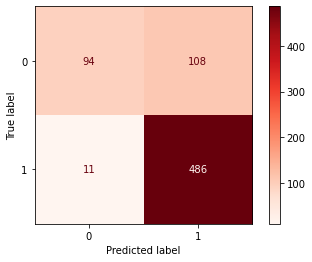

In [54]:
plot_confusion_matrix(gs, X_val, y_val, cmap='Reds', values_format='d');

In [55]:
y_pred = gs.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.47      0.61       202
           1       0.82      0.98      0.89       497

    accuracy                           0.83       699
   macro avg       0.86      0.72      0.75       699
weighted avg       0.84      0.83      0.81       699



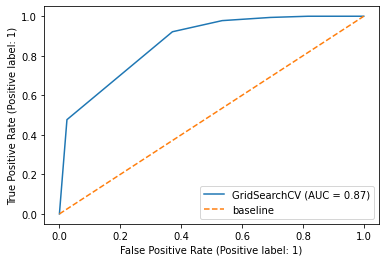

In [56]:
plot_roc_curve(gs, X_val, y_val)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

## ``TfidfVectorizer`` + `KNN` 

In [57]:
# set n_neighbors to be 5
knn_pipe_tfid = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

In [58]:
tcvec_pipe_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__min_df':[0.1],
    'tvec__max_df':[0.7],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [59]:
knn_pipe_tfid_gs = GridSearchCV(knn_pipe_tfid, 
                  param_grid=tcvec_pipe_params,
                  cv=5) # cross validate 5 times
knn_pipe_tfid_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'tvec__max_df': [0.7],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [0.1],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [60]:
preds = knn_pipe_tfid_gs.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
spec = tn / (tn + fp)

print(f"GridSearch Best Score for KNN + TFID: {knn_pipe_tfid_gs.best_score_}")
print('')
print(f"Train score for KNN + TFID: {knn_pipe_tfid_gs.score(X_train, y_train)}")
print(f"Test score for KNN + TFID: {knn_pipe_tfid_gs.score(X_val, y_val)}")
print('')
print('Specificity of for KNN + TFID:', spec)

GridSearch Best Score for KNN + TFID: 0.7606102966246164

Train score for KNN + TFID: 0.8111587982832618
Test score for KNN + TFID: 0.7696709585121603

Specificity of for KNN + TFID: 0.41089108910891087


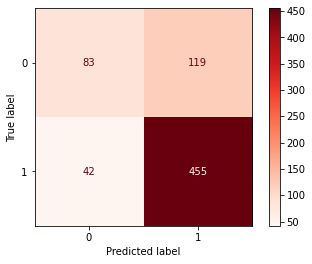

In [61]:
plot_confusion_matrix(knn_pipe_tfid_gs, X_val, y_val, cmap='Reds', values_format='d');

In [62]:
y_pred = knn_pipe_tfid_gs.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.41      0.51       202
           1       0.79      0.92      0.85       497

    accuracy                           0.77       699
   macro avg       0.73      0.66      0.68       699
weighted avg       0.76      0.77      0.75       699



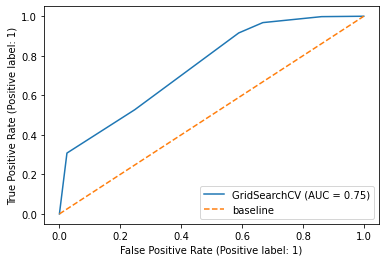

In [63]:
plot_roc_curve(knn_pipe_tfid_gs, X_val, y_val)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

## `CountVectorizer` + `MultiNominal NB`

In [64]:
nb_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [65]:
nb_gs = GridSearchCV(nb_pipe, # what object are we optimizing?
                  param_grid=cvec_pipe_params, # what parameters values are we searching?
                  cv=5)
nb_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'cvec__max_features': [1000, 1500, 2000, 2500, 3000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (2, 2)]})

In [66]:
preds = nb_gs.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
spec = tn / (tn + fp)

print(f"GridSearch Best Score for MNB + CVEC: {nb_gs.best_score_}")
print('')
print(f"Train score for MNB + CVEC: {nb_gs.score(X_train, y_train)}")
print(f"Test score for MNB + CVEC: {nb_gs.score(X_val, y_val)}")
print('')
print('Specificity for MNB + CVEC:', spec)

GridSearch Best Score for MNB + CVEC: 0.9575519945448348

Train score for MNB + CVEC: 0.9761564139246542
Test score for MNB + CVEC: 0.9599427753934192

Specificity for MNB + CVEC: 0.9405940594059405


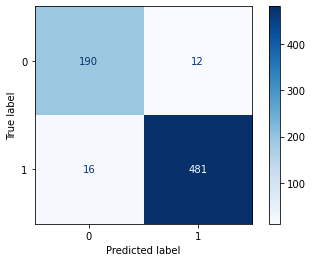

In [67]:
plot_confusion_matrix(nb_gs, X_val, y_val, cmap='Blues', values_format='d');

In [68]:
y_pred = nb_gs.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93       202
           1       0.98      0.97      0.97       497

    accuracy                           0.96       699
   macro avg       0.95      0.95      0.95       699
weighted avg       0.96      0.96      0.96       699



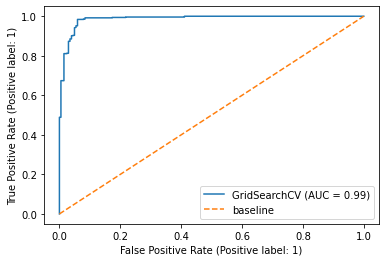

In [69]:
plot_roc_curve(nb_gs, X_val, y_val)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

## `TfidfVectorizer` + `MultiNominal NB`

In [70]:
nb_pipe_tfid = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [71]:
nb_pipe_tfid_gs = GridSearchCV(nb_pipe_tfid, 
                  param_grid=tcvec_pipe_params,
                  cv=5) # cross validate 5 times
nb_pipe_tfid_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.7],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [0.1],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [72]:
preds = nb_pipe_tfid_gs.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
spec = tn / (tn + fp)

print(f"GridSearch Best Score for MNB + TFID: {nb_pipe_tfid_gs.best_score_}")
print('')
print(f"Train score for MNB + TFID: {nb_pipe_tfid_gs.score(X_train, y_train)}")
print(f"Test score for MNB + TFID: {nb_pipe_tfid_gs.score(X_val, y_val)}")
print('')
print('Specificity of for MNB + TFID:', spec)

GridSearch Best Score for MNB + TFID: 0.7114922150244347

Train score for MNB + TFID: 0.7100619933237959
Test score for MNB + TFID: 0.7153075822603719

Specificity of for MNB + TFID: 0.024752475247524754


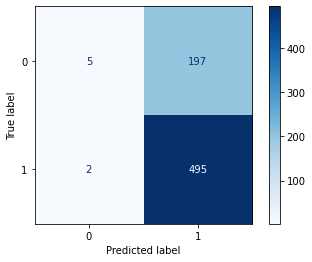

In [73]:
plot_confusion_matrix(nb_pipe_tfid_gs, X_val, y_val, cmap='Blues', values_format='d');

In [74]:
y_pred = nb_pipe_tfid_gs.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.02      0.05       202
           1       0.72      1.00      0.83       497

    accuracy                           0.72       699
   macro avg       0.71      0.51      0.44       699
weighted avg       0.72      0.72      0.61       699



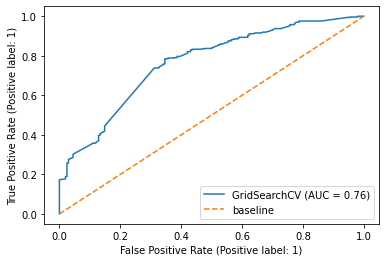

In [75]:
plot_roc_curve(nb_pipe_tfid_gs, X_val, y_val)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

## `CountVectorizer` + `Logistic Regression`

In [76]:
lr_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    (('lr',LogisticRegression()))
])

In [77]:
lr_gs = GridSearchCV(lr_pipe, # what object are we optimizing?
                  param_grid=cvec_pipe_params, # what parameters values are we searching?
                  cv=5)
lr_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             param_grid={'cvec__max_df': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'cvec__max_features': [1000, 1500, 2000, 2500, 3000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (2, 2)]})

In [78]:
preds = lr_gs.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
spec = tn / (tn + fp)

print(f"GridSearch Best Score for LR + CVEC: {lr_gs.best_score_}")
print('')
print(f"Train score for LR + CVEC: {lr_gs.score(X_train, y_train)}")
print(f"Test score for LR + CVEC: {lr_gs.score(X_val, y_val)}")
print('')
print('Specificity for LR + CVEC:', spec)

GridSearch Best Score for LR + CVEC: 0.9661529719286281

Train score for LR + CVEC: 0.9971387696709585
Test score for LR + CVEC: 0.9685264663805436

Specificity for LR + CVEC: 0.9257425742574258


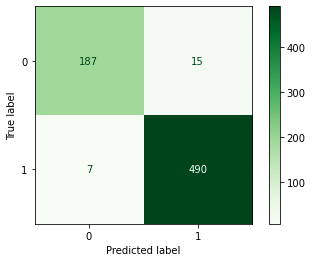

In [79]:
plot_confusion_matrix(lr_gs, X_val, y_val, cmap='Greens', values_format='d');

In [80]:
y_pred = lr_gs.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       202
           1       0.97      0.99      0.98       497

    accuracy                           0.97       699
   macro avg       0.97      0.96      0.96       699
weighted avg       0.97      0.97      0.97       699



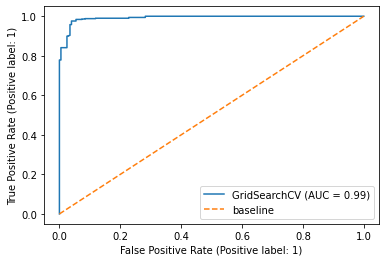

In [81]:
plot_roc_curve(lr_gs, X_val, y_val)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

# Best Performing Model (Top Predictor Tokens)

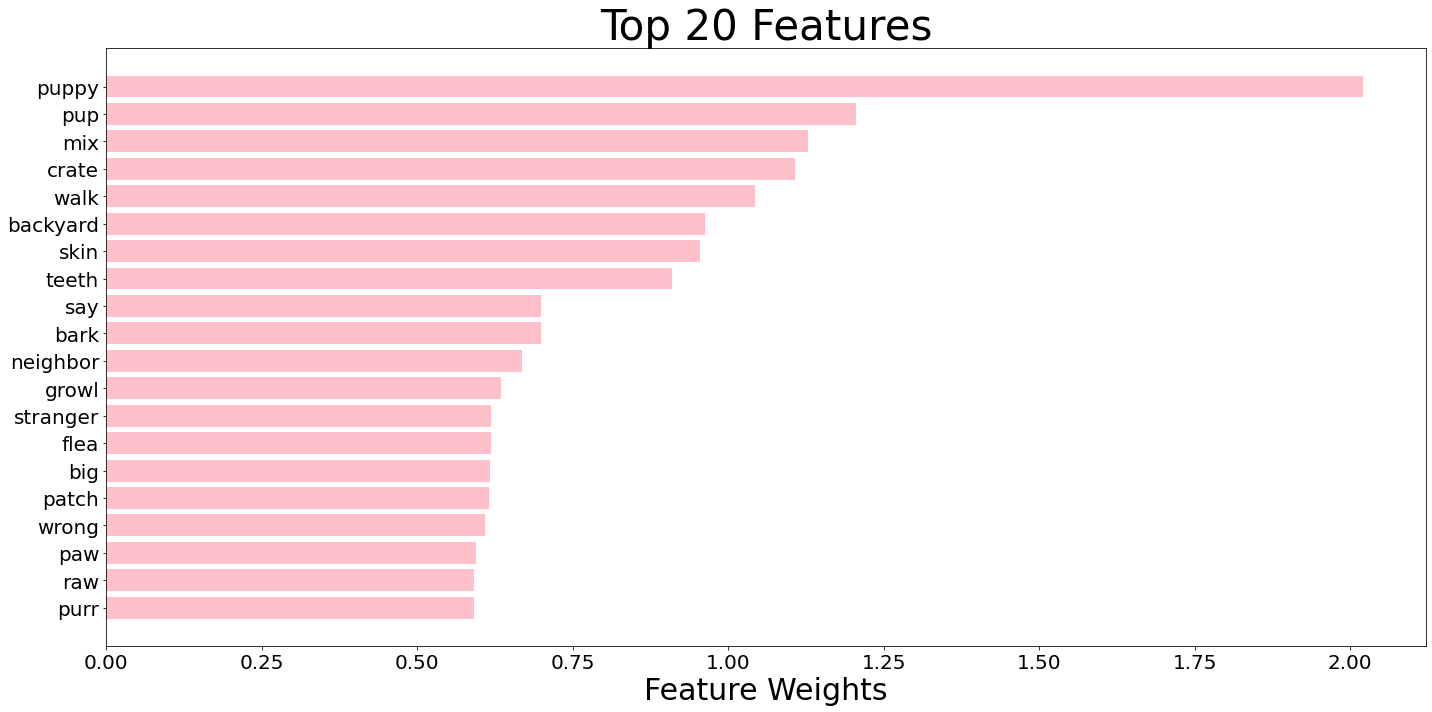

In [108]:
vocab = lr_gs.best_estimator_.named_steps['cvec'].get_feature_names()

coef = list(lr_gs.best_estimator_.named_steps['lr'].coef_[0])

feature_df = pd.DataFrame( {'top_words': vocab, 'importance': coef })

feature_df = feature_df.set_index('top_words')
feature_df = feature_df.sort_values('importance',ascending = False)

weights = feature_df['importance'].head(20).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = 'pink')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Feature Weights', fontsize=30)
plt.title(f'Top 20 Features', fontsize=42)
plt.tight_layout()

## `TfidfVectorizer` + `Logistic Regression`

In [83]:
lr_pipe_tfid = Pipeline([
    ('tvec', TfidfVectorizer()),
    (('lr',LogisticRegression()))
])

In [84]:
lr_pipe_tfid_gs = GridSearchCV(nb_pipe_tfid, 
                  param_grid=tcvec_pipe_params,
                  cv=5) # cross validate 5 times
lr_pipe_tfid_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.7],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [0.1],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [109]:
preds = lr_pipe_tfid_gs.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
spec = tn / (tn + fp)

print(f"GridSearch Best Score for LR + TFID: {lr_pipe_tfid_gs.best_score_}")
print('')
print(f"Train score for LR + TFID: {lr_pipe_tfid_gs.score(X_train, y_train)}")
print(f"Test score for LR + TFID: {lr_pipe_tfid_gs.score(X_val, y_val)}")
print('')
print('Specificity of for LR + TFID:', spec)

GridSearch Best Score for LR + TFID: 0.7114922150244347

Train score for LR + TFID: 0.7100619933237959
Test score for LR + TFID: 0.7153075822603719

Specificity of for LR + TFID: 0.024752475247524754


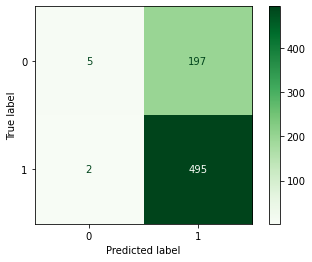

In [86]:
plot_confusion_matrix(lr_pipe_tfid_gs, X_val, y_val, cmap='Greens', values_format='d');

In [87]:
y_pred = lr_pipe_tfid_gs.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.02      0.05       202
           1       0.72      1.00      0.83       497

    accuracy                           0.72       699
   macro avg       0.71      0.51      0.44       699
weighted avg       0.72      0.72      0.61       699



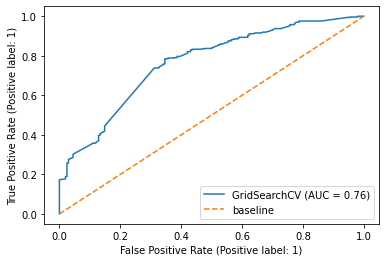

In [88]:
plot_roc_curve(lr_pipe_tfid_gs, X_val, y_val)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

## `CountVectorizer` + `Random Forest`

In [89]:
rf_pipe= Pipeline([
    ('cvec', CountVectorizer()),
    (('rf',RandomForestClassifier(n_estimators=200)))
])


In [90]:
rf_gs = GridSearchCV(rf_pipe, # what object are we optimizing?
                  param_grid=cvec_pipe_params, # what parameters values are we searching?
                  cv=5)
rf_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(n_estimators=200))]),
             param_grid={'cvec__max_df': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'cvec__max_features': [1000, 1500, 2000, 2500, 3000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (2, 2)]})

In [91]:
preds = rf_gs.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
spec = tn / (tn + fp)

print(f"GridSearch Best Score for RF + CVEC: {rf_gs.best_score_}")
print('')
print(f"Train score for RF + CVEC: {rf_gs.score(X_train, y_train)}")
print(f"Test score for RF + CVEC: {rf_gs.score(X_val, y_val)}")
print('')
print('Specificity for RF + CVEC:', spec)

GridSearch Best Score for RF + CVEC: 0.9723514035685874

Train score for RF + CVEC: 0.9990462565569862
Test score for RF + CVEC: 0.9713876967095851

Specificity for RF + CVEC: 0.9405940594059405


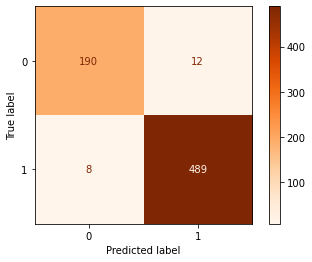

In [92]:
plot_confusion_matrix(rf_gs, X_val, y_val, cmap='Oranges', values_format='d');

In [93]:
y_pred = rf_gs.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       202
           1       0.98      0.98      0.98       497

    accuracy                           0.97       699
   macro avg       0.97      0.96      0.96       699
weighted avg       0.97      0.97      0.97       699



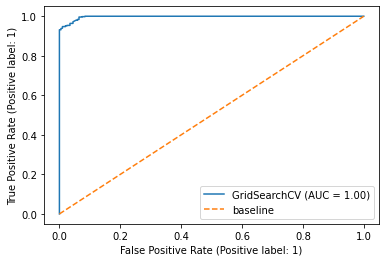

In [94]:
plot_roc_curve(rf_gs, X_val, y_val)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

## `TfidfVectorizer` + `Random Forest`

In [110]:
rf_pipe_tfid = Pipeline([
    ('tvec', TfidfVectorizer()),
    (('rf',RandomForestClassifier(n_estimators=200)))
])

In [111]:
rf_gs_tfid = GridSearchCV(rf_pipe_tfid, # what object are we optimizing?
                  param_grid=tcvec_pipe_params, # what parameters values are we searching?
                  cv=5)
rf_gs_tfid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(n_estimators=200))]),
             param_grid={'tvec__max_df': [0.7],
                         'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__min_df': [0.1],
                         'tvec__ngram_range': [(1, 1), (1, 2)]})

In [112]:
preds = rf_gs_tfid.predict(X_val)
tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
spec = tn / (tn + fp)

print(f"GridSearch Best Score for RF + TFID: {rf_gs_tfid.best_score_}")
print('')
print(f"Train score for RF + TFID: {rf_gs_tfid.score(X_train, y_train)}")
print(f"Test score for RF + TFID: {rf_gs_tfid.score(X_val, y_val)}")
print('')
print('Specificity for RF + TFID:', spec)

GridSearch Best Score for RF + TFID: 0.8192612796908738

Train score for RF + TFID: 0.8445398187887458
Test score for RF + TFID: 0.8297567954220315

Specificity for RF + TFID: 0.5346534653465347


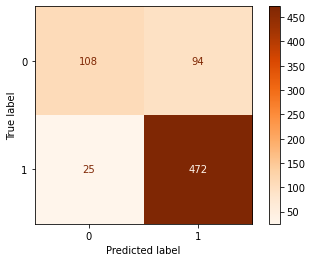

In [113]:
plot_confusion_matrix(rf_gs_tfid, X_val, y_val, cmap='Oranges', values_format='d');

In [99]:
y_pred = rf_gs_tfid.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.47      0.60       202
           1       0.82      0.96      0.88       497

    accuracy                           0.82       699
   macro avg       0.82      0.71      0.74       699
weighted avg       0.82      0.82      0.80       699



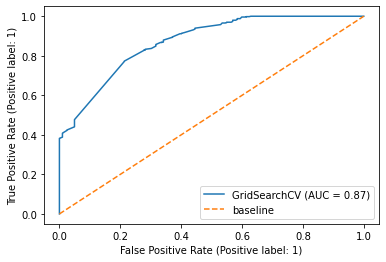

In [100]:
plot_roc_curve(rf_gs_tfid, X_val, y_val)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

# Conclusion and Recommendations
## Summary of model's performances

|Model|Vectorizer|Train Score|Test SCore|Specificity|F1 Score|
|---|---|---|---|---|---|
|**KNN**|CountVectorizer|0.90|0.83|0.47|0.83|
|**KNN**|TDIFVectorizer|0.81|0.77|0.41|0.77|
|**Nominal Naive Bayers**|CountVectorizer|0.98|0.96|0.95|0.96|
|**Nominal Naive Bayers**|TDIFVectorizer|0.71|0.72|0.02|0.72|
|**Logistic Regression**|CountVectorizer|0.99|0.97|0.93|0.97|
|**Logistic Regression**|TDIFVectorizer|0.71|0.72|0.02|0.72|
|**Random Forest**|CountVectorizer|0.99|0.97|0.94|0.97|
|**Random Forest**|TDIFVectorizer|0.84|0.83|0.53|0.82|

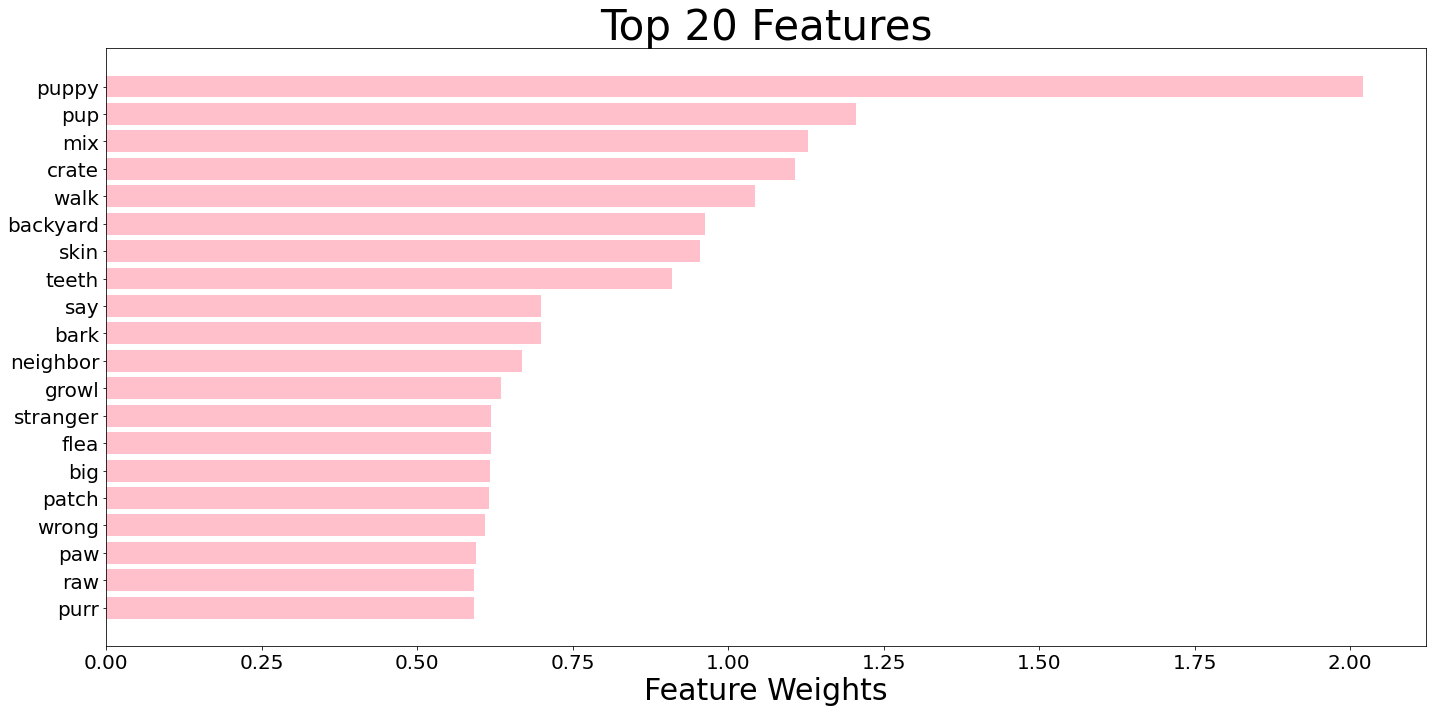

# Conclusion and Recommendations <a name="final"></a>

As we can see the weakest performing model are `Logistic Regression` + `TDIF` and `Nominal NB` + `TDIF`, so we will be using that as the baseline model to compare our results.
Our Top Performing model are `Logisitic Regression` + `CVEC` and `Random Forest` + `CVEC`. 
The top words that influence the prediction of a post being classified are `puppy`, `pup` and `mix`. A post will be more likely to be classified into a DogAdvice subreddit with the unique keywords and the remaining posts will be classified into CatAdvice posts.
During EDA, majority of DogAdvice post were asking for advice for caring of older dogs, with words such as anxiety and depression. Majority of CatAdvice posts were asking for advice for caring of new and young cats.

# Model Limitations

The Naive Bayers works under the theoretical impression that the features are unique and independent of each other, however that is not always feasible in real world settings. Due to time constraint, only a small subset of data 2000 were collected from the Reddit, and there is a chance of bias to certain topics that have been repeated during the collected time period. The origin of users posting onto Reddit might influence the purpose of their posts as different countries (different pet regulations) might have an influence keywords used in posts.
Majority of DogAdvice posts contain visual media in the form of pictures or videos whereas there is a lack of visual media in CatAdvice, as the Cat subreddit has a stricter regulation. One of the regulation of the CatAdvice restricts users from asking medical advice, which might explain the lack of posts regarding older cats, as older animals have a greater need for medical advice than young kittens.